# 1. Introduction:

  In today's game industry, player characteristics and behavior analysis have proven to be an important way to improve player engagement and optimize operational strategy. Some research points out that players' characteristics, such as active time period, engagement, and interaction modes, can effectively predict the future action and performance of players. (Mustač et al., 2022) In game Tom Clancy’s The Division 2, research create a multimodal Dataset, collecting players’ real gameplay videos, gamepad action, and time-continuous annotated engagement. Their research found that using only player input and game footage, the accuracy of players ‘engagement prediction can reach up to 72%, best at 88%. This research proves that even not knowing the complicated information of games, relying only on the players’ characteristics and behavior, we can still predict the players’ engagement. (Pinitas et al., 2023)

By taking inspiration of this case, we also want to use the dataset `players.csv` dataset collected by Minecraft to explore broad question 1, which asks: What player characteristics and behaviors are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types? More specifically, we want to know can the experience level of players, total hours played by player, and the age of players can help predict whether they will subscribe to a PLAICraft newsletter in the `players.csv` dataset? To do this we will perform a K-NN classifcation model.

The dataset we will use to analyze this project is `players.csv`. The predictors we will use includes the experience level of the player `experience` (character type in players.csv, but is changed to factor), the total hours of player `played_hours` (double),  and age of the player `age` (double). Our response variable in this model is whether the user subscribes to the newsletter `subscribe` (logical in players.csv, but is changed to factor).

There are some variables we will will not use from dataset, such as the hashed email of players `hashedEmail` (character), and the name of players `name` (character), as they do not provide quantitative or characteritics for the players. We also will not include the gender of players `gender` (character) since the K-NN model calculates distances of the nearest neighbors to the unknown observation, however, gender includes descrete categories. While categorical variables could be converted to numeric values, this is not appropriate as there is no meaningful numeric relationship 

### 1.2 Loading the Libraries and Dataset Required

In [23]:
library(tidyverse)
library(janitor)
library(repr)
library(tidymodels)
library(rsample)

# Downloading the data
download.file(url= "https://raw.githubusercontent.com/chl0ehuang/Project-003-15/refs/heads/main/players.csv", destfile = "players.csv")

# Loading the players.csv data set
players_data <- read_csv("players.csv")
head(players_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


# 2. Methods and Results
### 2.1 Tidying and Changing Variable The Types and Names

Out of the 7 variables, the columns `hashedEmail`, `name` , and `gender` is removed as through the filter function as it is not relevant to our classsification model. The `Age` column is also renamed with lowercases allowing consistency between column names. Additonally, the observations in `subscribe` are categories, therefore the column type are mutated to a factor type.  

After wrangling and tidying the data in the `players` object data frame, the data appears data as each variable forms a column, each observation forms a row, and each cell is a single measurment.

In [13]:
#Tidying and modifying the data
players <- players_data |>
    select(-hashedEmail, -name, -gender) |> 
    rename(age = Age)|>
    mutate(subscribe = as_factor(subscribe)) |>     
    mutate(subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE"))
head(players)

experience,subscribe,played_hours,age
<chr>,<fct>,<dbl>,<dbl>
Pro,Yes,30.3,9
Veteran,Yes,3.8,17
Veteran,No,0.0,17
Amateur,Yes,0.7,21
Regular,Yes,0.1,21
Amateur,Yes,0.0,17


### 2.2 Summary Statistics for `players.csv`

In [14]:
#Total Number of Players and Percent of Players that Subscribe To The Newsletter
yes_subscribe <- players |>
    filter(subscribe == "Yes")|>
    summarize(yes_subscribe_count = n())

yes_no_subscribe <- players_data |>
    summarize(total_num_of_players = n())|>
    bind_cols(yes_subscribe) |>
    mutate(percentage_total_of_yes_subscribe = (yes_subscribe_count/total_num_of_players)*100) |>
    round(digits = 2)|>
    select(-yes_subscribe_count)
yes_no_subscribe

#Mean, Minimum, and Maximum Age of Players in Data Set
mean_age <- players_data |>
    rename(age = Age)|>
    summarize(mean_age_of_players = mean(age, na.rm=TRUE), min_age = min(age, na.rm=TRUE), max_age = max(age, na.rm=TRUE))|>
    round(digits = 2)
mean_age

#Mean, Minimum, and Maximum Hours Played
mean_hours <- players_data |>
    summarize(mean_hours_played = mean(played_hours), min_hours = min(played_hours), max_hours = max(played_hours)) |>
    round(digits = 2)
mean_hours

#Total Number of Players For Each Experience Level
experience_level <- players_data |>
    group_by(experience)|>
    summarize(num_of_players = n())
experience_level

#Total Number of Players For Each Gender Identity
gender <- players_data |>
    group_by(gender)|>
    summarize(num_of_players = n())
gender

total_num_of_players,percentage_total_of_yes_subscribe
<dbl>,<dbl>
196,73.47


mean_age_of_players,min_age,max_age
<dbl>,<dbl>,<dbl>
21.14,9,58


mean_hours_played,min_hours,max_hours
<dbl>,<dbl>,<dbl>
5.85,0,223.1


experience,num_of_players
<chr>,<int>
Amateur,63
Beginner,35
Pro,14
Regular,36
Veteran,48


gender,num_of_players
<chr>,<int>
Agender,2
Female,37
Male,124
Non-binary,15
Other,1
Prefer not to say,11
Two-Spirited,6


### 2.3 Graphing of Our Predictors vs `subscribe`

`summarise()` has grouped output by 'experience'. You can override using the
`.groups` argument.


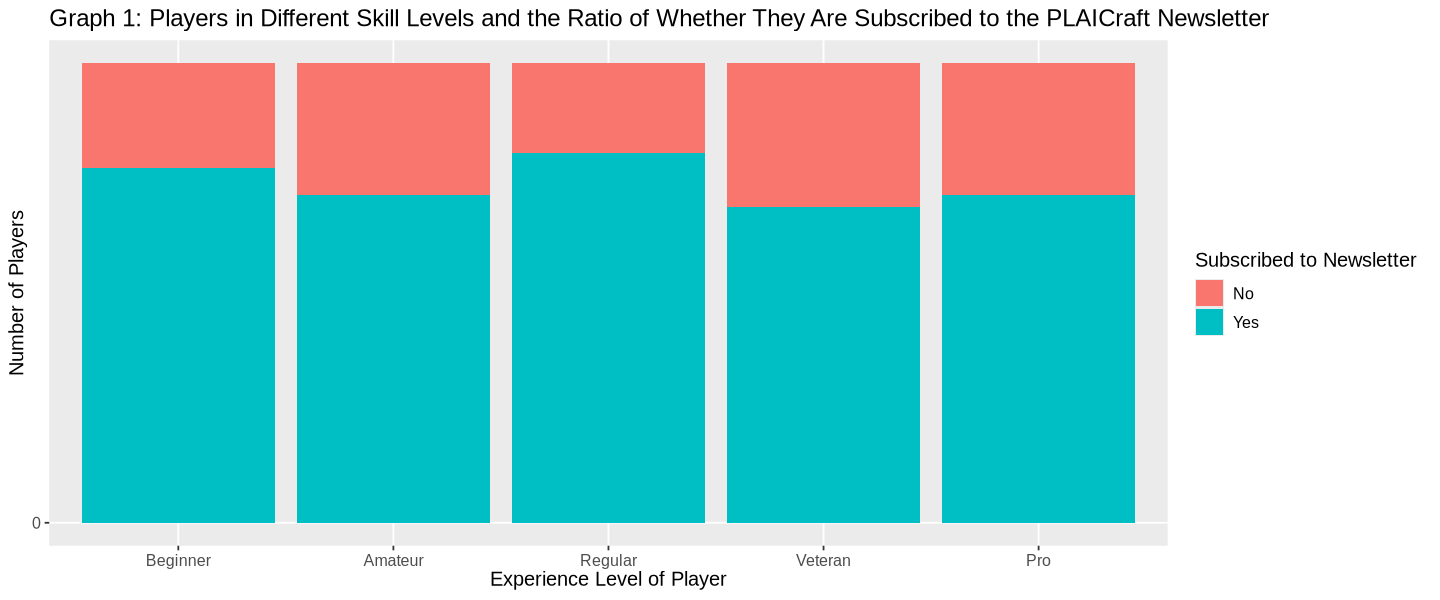

In [15]:
options(repr.plot.width = 12, repr.plot.height = 5)

#Graph 1: Players in Different Experience Levels and the Ratio of Whether They Are Subscribed to the PLAICraft Newsletter
experience_distribution <- players |>
    group_by(experience, subscribe)|>
    summarize(number_of_players = n()) |>
    mutate(experience = factor(experience, levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"))) |>
    ggplot(aes(x = experience, y = number_of_players, fill = subscribe)) +
    geom_bar(stat= "identity", position = "fill") +
    labs(x = "Experience Level of Player", y = "Number of Players", fill = "Subscribed to Newsletter") +
    ggtitle("Graph 1: Players in Different Skill Levels and the Ratio of Whether They Are Subscribed to the PLAICraft Newsletter") +
    theme(text = element_text(size = 12)) +
    scale_y_continuous(breaks = seq(from = 0, to = 250, by = 10))
experience_distribution

It apppears that those with Regular experience are most likely to sign up for the newsletter, while Veterans are the least likely to.

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


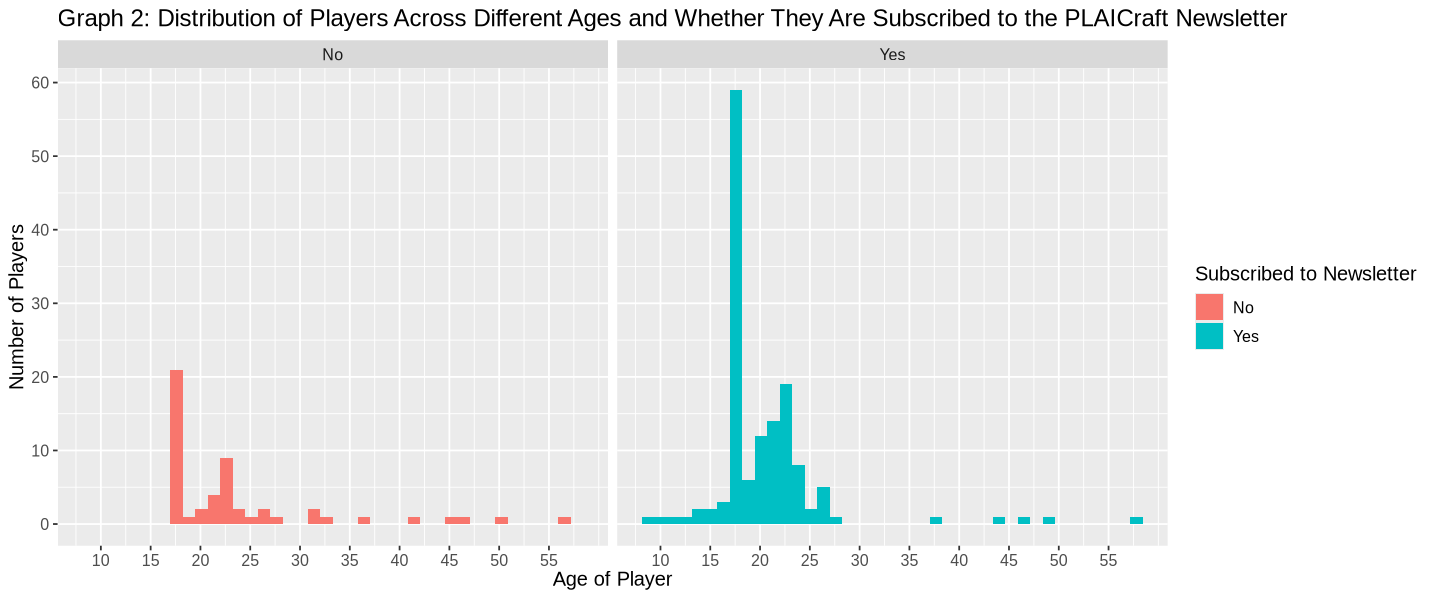

In [16]:
#Graph 2: Distribution of Players Across Different Ages and Whether They Are Subscribed to the PLAICraft Newsletter
age_disribution <- players |>
    ggplot(aes(x = age, fill = subscribe)) +
    geom_histogram(bins=40) +
    facet_grid(cols = vars(subscribe)) +
    labs(x = "Age of Player", y = "Number of Players", fill = "Subscribed to Newsletter") +
    ggtitle("Graph 2: Distribution of Players Across Different Ages and Whether They Are Subscribed to the PLAICraft Newsletter") +
    theme(text = element_text(size = 12)) +
    scale_x_continuous(breaks = seq(from = 10, to = 57, by = 5)) +
    scale_y_continuous(breaks = seq(from = 0, to = 80, by = 10))
age_disribution

By looking at the graphs, the mean age of player of those who sign up for the newsletter are younger than the mean age of those who do not.

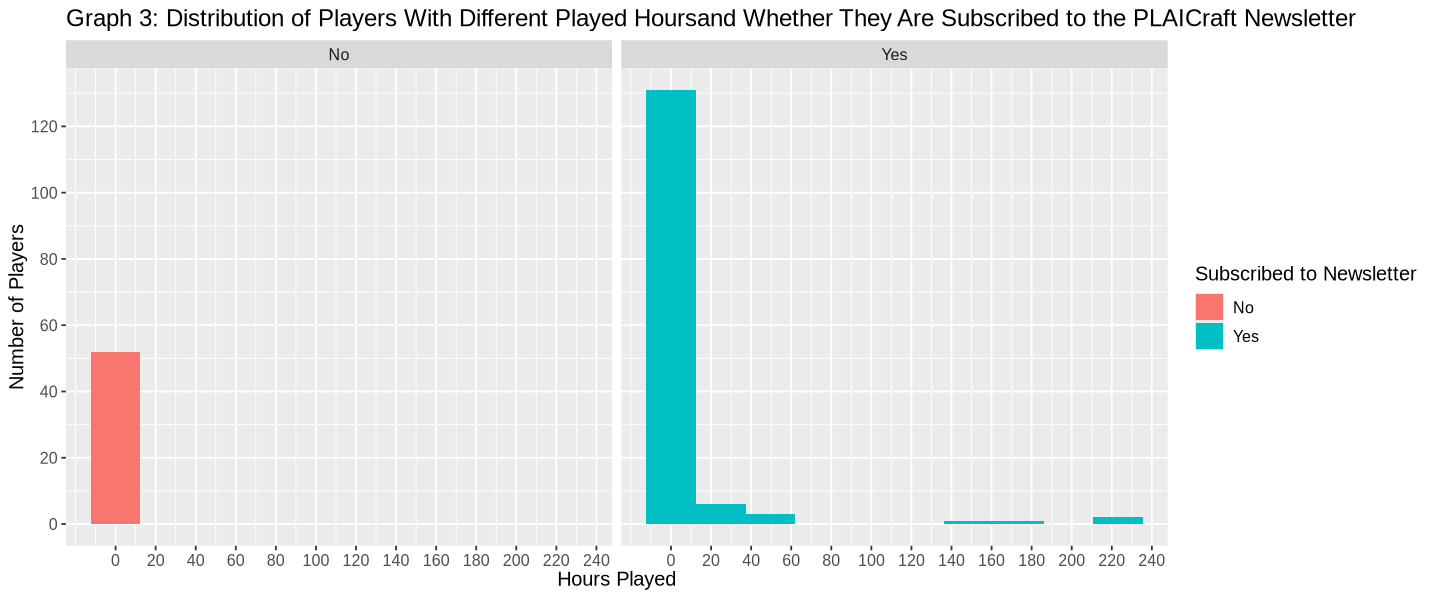

In [17]:
#Graph 3: Distribution of Players With Different Played Hours and Whether They Are Subscribed to the PLAICraft Newsletter
hours_disribution <- players |>
    ggplot(aes(x = played_hours, fill = subscribe)) +
    geom_histogram(bins=10) +
    facet_grid(cols = vars(subscribe)) +
    labs(x = "Hours Played", y = "Number of Players", fill = "Subscribed to Newsletter") +
    ggtitle("Graph 3: Distribution of Players With Different Played Hoursand Whether They Are Subscribed to the PLAICraft Newsletter") +
    theme(text = element_text(size = 12)) +
    scale_x_continuous(breaks = seq(from = 0, to = 240, by = 20)) +
    scale_y_continuous(breaks = seq(from = 0, to = 250, by = 20))
hours_disribution

The graph shows that those who play more hours are more likey to sign up for the newsletter while those who play less hours are less likey to.

### 2.4 The K-NN Classification Model and Preparing the Dataset for the Model
The variables `experience`, `played_hours`, and `age` will serve as predictors in a K-NN classification model to predict `subscribe`, indicating whether a PLAICraft user will subscribe to the newsletter. A 70/30 split of training/testing will be used due to the small dataset, along with a 5-fold cross-validation to determine the appropriate k-value. 

The variable `age` contains missing observations; observations with missing age will be filtered out to allow distance calculations for the observations. Addionally, since the K-NN model will be used, the predictors must be numerical for meaningful Euclidean distance calculations. Therefore, the variable `experience` will be converted to the double data type from values 1-5 to allow for psuedo numeric varibles. This will mean that larger numbers indicate players under categories with more experience while smaller values indicate players with lower expereince.

In [18]:
players_wrangled <- players |>
    filter(age != 'NA') |>
    mutate(experience = recode(
                    experience,
                    "Beginner" = 1,
                    "Regular"  = 2,
                    "Amateur"  = 3,
                    "Pro"      = 4,
                    "Veteran"  = 5)) 
head(players_wrangled)

experience,subscribe,played_hours,age
<dbl>,<fct>,<dbl>,<dbl>
4,Yes,30.3,9
5,Yes,3.8,17
5,No,0.0,17
3,Yes,0.7,21
2,Yes,0.1,21
3,Yes,0.0,17


In [19]:
set.seed(67)

# 1. Make Training and Testing Data
players_split <- initial_split(players_wrangled, prop = 0.7, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)



# 2. Make Cross-Validation with 5 Folds
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)


# 3. Make Recipe, where all Predictors Are Scaled to Prevent Uneven Weighing When Calculating Distances
players_recipe <- recipe(subscribe ~ experience + played_hours + age, data = players_train) |>
                    step_center(all_predictors())|>
                    step_scale(all_predictors())

# 4. Find the Best K with Cross Validation
knn_tune <- nearest_neighbor(
                neighbors = tune(),
                weight_func = 'rectangular') |>
            set_mode('classification') |>
            set_engine('kknn')

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

knn_results <- workflow() |>
       add_recipe(players_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = players_vfold, grid = k_vals)|>
  collect_metrics()

best_k <- knn_results |> 
    filter(.metric == "accuracy") |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(neighbors)

# 5. Make final model with best K value
final_knn_model_spec <- nearest_neighbor(
    neighbors = best_k,
    weight_func = "rectangular") |>
        set_mode("classification") |>
            set_engine("kknn")

# 6. Fit Model
final_knn_model <- workflow() |>
                    add_recipe(players_recipe) |>
                    add_model(final_knn_model_spec) |>
                    fit(data = players_train)

# 3. Model Evaluation

### 3.1 Metrics: Accuracy and Cohen’s kappa

In [20]:
players_test_predictions <- predict(final_knn_model, players_test) |>
                                    bind_cols(players_test)

prediction_accuracy <- players_test_predictions |>
         metrics(truth = subscribe, estimate = .pred_class)             
prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.72881356
kap,binary,0.05410822


### 3.2 The Confusion Matrix

In [21]:
players_mat <- players_test_predictions |>
                conf_mat(truth = subscribe, estimate = .pred_class)
players_mat

          Truth
Prediction No Yes
       No   1   1
       Yes 15  42

### 3.3 Graphing Our Analysis Statistics

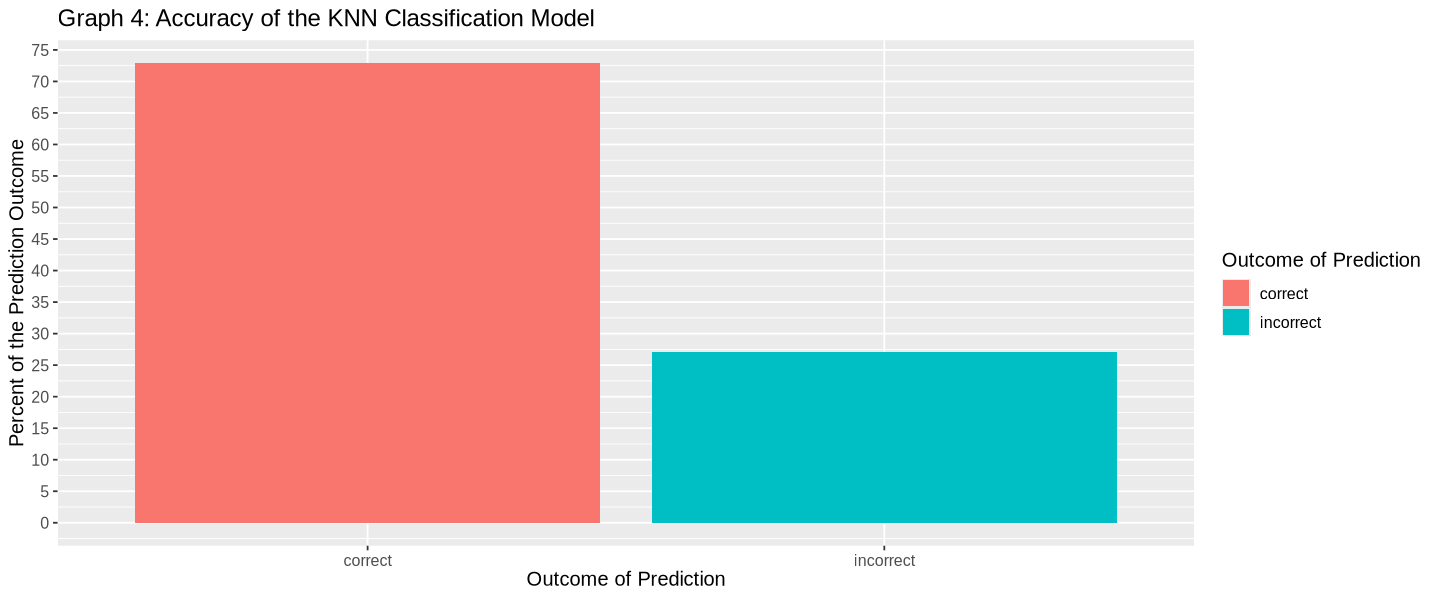

In [22]:
# Graph 4: Accuracy of the KNN Classification Model
players_test_stats <- players_test_predictions |> 
    summarize(total_num_of_players = n(), correct = sum(.pred_class == subscribe)/total_num_of_players *100, incorrect = sum(.pred_class != subscribe)/total_num_of_players*100)

players_test_graph <- players_test_stats |>
    pivot_longer(cols = c(correct, incorrect), names_to = "type", values_to = "count") |>
    ggplot(aes(x = type, y= count, fill = type)) +
    geom_bar(stat = "identity") +
    labs(x= "Outcome of Prediction", y = "Percent of the Prediction Outcome", fill = "Outcome of Prediction") +
    ggtitle("Graph 4: Accuracy of the KNN Classification Model") +
    theme(text = element_text(size = 12)) +
    scale_y_continuous(breaks = seq(from = 0, to = 100, by = 5))
players_test_graph

#Note: x-axis label and legend lable is redundant

# 4. Discussion

Our analysis explored whether three player characteristics: experience, played hours and age could help with predicting whether a player would subscribe to the newsletter. 

The modeling result shows a few patterns: 1.Players with regular experience levels appeared most likely to subscribe, while veteran players were the least interested. 2. In terms of age, subscribers tended to be younger on average than non-subscribers, although the overlap between the two groups indicates that age is not a strong or decisive predictor on its own. 3. Total hours played shows neary no pattern, a large number of players reporting 0 hours makes this relationship difficult to interpret confidently. After omitting all the observations with statistics of 0 hours played, it showed a slightly positive trend, where players who reported more hours were more likely to subscribe.

To evaluate how well these predictors work together, we trained a K-NN classification model using cross-validation to tune the nnumber of neighbours. The best-performing model achieved a test accuracy of 0.73. This suggested that the model is able to correctly classify subscription status better than random guessing, but still have notable limitations. The predictors show broad tendencies but not strong or clean separations between very low Cohen's kappa = 0.05, which further indicates that although the accuracy is reasonable the model does not perform much better. The confusion matrix reinforces this, where the model correctly identifies most ture subscribers, but misclassifies many individuals as subscribers.

This finding partly match expectations. It is intuitive that players who are more engaged, regular experience levels and higher played houres may be more interested in subscribing to a newsletter. The weak role of age and the inconsistent reporting of played hours highlight the limitations of the self-reported gaming data. Moreover, the poor performance in identifying non-subscribers suggests the predictors we used may not capture the real factors that drive a player's interest in signing up. 

The analysis has a few practical implications: 1. for PlaiCraft, the results suggest that engagement signals such as experience level and play activity may be more useful for targeted newsletter outreach than demographic features like age. 2.Relying on behavioral metrics is not sufficient, given the model's limitation in predictive power. The company may likely benefit from collecting additional relevant information to build a more reliable predictive model.

Looking forward, this project opens several future questions: Which additional player characteristics would meaningfully improve predictive accuracy? Why do veteran players appear least likely to subscribe? Is the large group of 0 hour played being reported a genuine feature of the population or a data quality problem?

Overall, while the current model provides initial insight into subscription behavior, our findings highlight the need for predictors that more meaning fully relect players and more robust modelling to fully understand what drives PlaiCraft newsletter engagement.

# 5. References

1.	Mustač, K., Bačić, K., Skorin-Kapov, L., & Sužnjević, M. (2022). Predicting Player Churn of a Free-to-Play Mobile Video Game Using Supervised Machine Learning. Applied Sciences, 12(6), 2795. https://doi.org/10.3390/app12062795
2.	Pinitas, K., Renaudie, D., Thomsen, M., Barthet, M., Makantasis, K., Liapis, A., & Yannakakis, G. N. (2023). Predicting Player Engagement in Tom Clancy’s The Division 2: A Multimodal Approach via Pixels and Gamepad Actions. INTERNATIONAL CONFERENCE ON MULTIMODAL INTERACTION, 488–497. https://doi.org/10.1145/3577190.3614203